# Modelo ML - Random Forest

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_CA = pd.read_csv("./data/CalidadAire.csv")
df_CA = df_CA[df_CA["ESTACION"]==8]
df_CA['FECHA'] = pd.to_datetime(df_CA['FECHA'], format = '%Y-%m-%d %H:%M:%S')

In [3]:
df_Tr = pd.read_csv("./data/Trafico.csv")
df_Tr = df_Tr[df_Tr["estacion_CalidadAire"]==8]
df_Tr['fecha'] = pd.to_datetime(df_Tr['fecha'], format = '%Y-%m-%d %H:%M:%S')

In [4]:
df = pd.merge(df_CA, df_Tr, left_on=["FECHA", "ESTACION"], right_on=["fecha", "estacion_CalidadAire"])

In [5]:
df.drop(['Unnamed: 0_x', 'ESTACION', 'estacion_CalidadAire', 'fecha', 'Unnamed: 0_y', 'vmed'], 
        axis=1, inplace=True)

In [6]:
df.head()

,FECHA,SO2,CO,NO2,PM10,O3,intensidad,ocupacion,carga
0,2014-01-01 01:00:00,6.0,0.2,40.0,24.0,24.0,4.333333,1.666667,4.333333
1,2014-01-01 02:00:00,6.0,0.2,42.0,17.0,24.0,4.000000,5.250000,4.750000
2,2014-01-01 03:00:00,6.0,0.2,29.0,11.0,29.0,3.000000,0.250000,2.250000
3,2014-01-01 04:00:00,6.0,0.1,21.0,8.0,35.0,0.000000,0.000000,0.000000
4,2014-01-01 05:00:00,6.0,0.1,23.0,7.0,35.0,3.000000,0.000000,2.250000


In [7]:
# Dado un dataframe con diferentes series temporales, devuelve el dataframe 
# con los diferentes lags generados para cada una de sus columnas

def generaLags(df, max_lag, min_lag=0, separator='_'):
    values=[]
    for i in range(min_lag, max_lag + 1):
        values.append(df.shift(i).copy())
        values[-1].columns = [c + separator + str(i) for c in df.columns]
        
    return pd.concat(values, axis=1)

In [8]:
max_lag = 400
df_lags = generaLags(df[['SO2', 'CO', 'NO2', 'PM10', 'O3', 'intensidad', 'ocupacion', 'carga']], max_lag)

In [9]:
df_lags.head()

,SO2_0,CO_0,NO2_0,PM10_0,O3_0,intensidad_0,ocupacion_0,carga_0,SO2_1,CO_1,...,ocupacion_399,carga_399,SO2_400,CO_400,NO2_400,PM10_400,O3_400,intensidad_400,ocupacion_400,carga_400
0,6.0,0.2,40.0,24.0,24.0,4.333333,1.666667,4.333333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.0,0.2,42.0,17.0,24.0,4.000000,5.250000,4.750000,6.0,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.0,0.2,29.0,11.0,29.0,3.000000,0.250000,2.250000,6.0,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.0,0.1,21.0,8.0,35.0,0.000000,0.000000,0.000000,6.0,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.0,0.1,23.0,7.0,35.0,3.000000,0.000000,2.250000,6.0,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_lags = pd.concat([df['FECHA'], df_lags], axis=1)

In [11]:
df_lags=df_lags.dropna()

In [12]:
# Creando los conjuntos de datos de train y test

df_train = df_lags[:int(0.8*(len(df_lags)))]
df_test  = df_lags[int(0.8*(len(df_lags))):]

In [13]:
cols_predictors   = df_lags.columns[6:]
cols_predictibles = df_lags.columns[1:6]

In [14]:
X = df_train[cols_predictors]
y = df_train[cols_predictibles]

In [15]:
X_test = df_test[cols_predictors]
y_test = df_test[cols_predictibles]

In [16]:
# Scaling Variables 
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_scale = scaler.fit_transform(X)

In [17]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

# Crear el grid con los parámetros a optimizar
param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 50, 100],
              'n_estimators': [100, 500]}

cv = ShuffleSplit(n_splits=1, test_size=0.20, random_state=0)

rfr = GridSearchCV(RandomForestRegressor(),
                   param_grid=param_grid,
                   scoring="neg_mean_squared_error",
                   n_jobs=1, 
                   pre_dispatch='2*n_jobs',
                   cv=cv)

In [18]:
# Entreno el modelo para obtener los mejores parámetros
#rfr.fit(X_scale, y)

# Visualizo mejores parámetros
#print(rfr.best_score_)
#print(rfr.best_params_) 

In [19]:
# Instanciamos al modelo con los parámetros óptimos
rfr = RandomForestRegressor(n_estimators=100,
                            max_depth=20,
                            max_features='auto',
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            bootstrap=False)

# Entreno el modelo para obtener las columnas más importantes para el modelo
rfr.fit(X_scale, y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

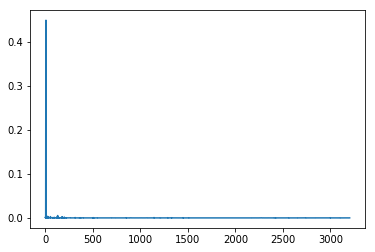

In [20]:
# Gráfica de la importancia de cada columna
plt.plot(rfr.feature_importances_)

In [21]:
# Me quedo con las 40 columnas más importantes en el modelo
import pandas as pd

feature_importances = pd.DataFrame(rfr.feature_importances_,
                                   index = cols_predictors,
                                   columns=['importance'])

cols_importances = feature_importances.sort_values('importance', ascending=False)[0: 40].index

In [22]:
cols_importances

Index(['O3_1', 'NO2_1', 'PM10_1', 'carga_16', 'O3_3', 'carga_3', 'PM10_7',
       'NO2_2', 'O3_22', 'ocupacion_3', 'PM10_2', 'ocupacion_15',
       'intensidad_25', 'NO2_23', 'carga_17', 'ocupacion_4', 'O3_2', 'SO2_1',
       'carga_0', 'O3_12', 'PM10_4', 'PM10_3', 'intensidad_0', 'ocupacion_10',
       'ocupacion_16', 'NO2_3', 'carga_39', 'intensidad_143', 'O3_23',
       'ocupacion_63', 'ocupacion_0', 'carga_181', 'PM10_28', 'ocupacion_161',
       'ocupacion_18', 'O3_4', 'intensidad_166', 'NO2_47', 'carga_62',
       'PM10_375'],
      dtype='object')

In [23]:
# Construyo de nuevo el conjunto de datos de train y test con las columnas con mayor importancia,
# y vuelvo a normalizar datos de train con RobustScaler
X = df_train[cols_importances]
X_test = df_test[cols_importances]
scaler = RobustScaler()
X_scale = scaler.fit_transform(X)

In [24]:
# Entreno el modelo para predecir
rfr.fit(X_scale, y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [25]:
# Con lo que voy a comparar la predicción
y_test.head()

,SO2_0,CO_0,NO2_0,PM10_0,O3_0
35397,7.0,0.3,25.0,6.0,74.25
35398,6.0,0.3,30.0,10.0,70.40
35399,6.0,0.3,31.0,5.0,67.45
35400,6.0,0.3,31.0,11.0,67.62
35401,6.0,0.3,33.0,12.0,66.06


In [26]:
# Hago prediccion sobre test
prediction_test = rfr.predict(X_test)
prediction_test

array([[  8.16 ,   0.346,  66.12 ,  44.48 , 122.75 ],
       [  8.16 ,   0.347,  66.15 ,  44.54 , 122.85 ],
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       ...,
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ]])

In [27]:
#Convierto prediction a dataframe
cols = cols_predictibles
pred_test = pd.DataFrame(index=range(0,len(prediction_test)),columns=[cols])

for j in range(0,5):
    for i in range(0, len(prediction_test)):
       pred_test.iloc[i][j] = prediction_test[i][j]

In [28]:
# Calculo el RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

print('RMSE values')
media=0
for i in cols:
    print(i, ':', sqrt(mean_squared_error(pred_test[i], y_test[i])))
    media =+ sqrt(mean_squared_error(pred_test[i], y_test[i]))
    
media = media/5
print("El error medio es: ", media)

RMSE values
SO2_0 : 4.137435612035518
CO_0 : 0.24259836294490342
NO2_0 : 34.71339886683454
PM10_0 : 34.18085476978372
O3_0 : 78.4589061090397
El error medio es:  15.69178122180794


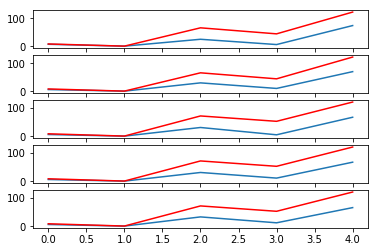

In [29]:
# Plot comparativo entre los datos de test y las prediccciones del modelo
for i in range(0, len(cols_predictibles)):
    plt.subplot(len(cols_predictibles), 1, i+1)
    plt.plot(y_test.values[i][-24:])
    plt.plot(pred_test.values[i][-24:],color="red")

In [39]:
# Predecir próximos valores
horas_a_predecir = 24*15
prediction = rfr.predict(df_lags[cols_importances][-horas_a_predecir:])
prediction

array([[  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       ...,
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ],
       [  8.56 ,   0.443,  72.05 ,  52.98 , 121.54 ]])

In [40]:
#Convierto prediccion a dataframe
cols = cols_predictibles
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])

for j in range(0,5):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [41]:
# Gráficas de datos actuales y predicción
datos_actuales = df[['SO2', 'CO', 'NO2', 'PM10', 'O3']]
datos_actuales.index = df['FECHA']
#datos_actuales.drop(['FECHA'], axis=1, inplace=True)

In [42]:
datos_prediccion = pred

# Generando fechas para la predicción y asignándola de índice en el dataframe
import datetime
datelist = pd.date_range(max(datos_actuales.index) + datetime.timedelta(hours=1), 
                         freq='H', periods=len(pred))

datos_prediccion.index = datelist
datos_prediccion.columns = datos_actuales.columns

datos_prediccion

,SO2,CO,NO2,PM10,O3
2019-04-01 00:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 01:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 02:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 03:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 04:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 05:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 06:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 07:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 08:00:00,8.56,0.443,72.05,52.98,121.54
2019-04-01 09:00:00,8.56,0.443,72.05,52.98,121.54


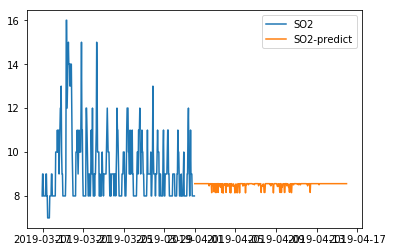

In [43]:
# Sacando gráfica de cada sustancia contaminante con su predicción:

# SO2

df_all = pd.merge(pd.DataFrame(datos_actuales['SO2'][-horas_a_predecir:]), 
                  pd.DataFrame(datos_prediccion['SO2']), 
                  how = 'outer', left_index=True, right_index=True)
plt.plot(df_all)
plt.legend(('SO2', 'SO2-predict'))

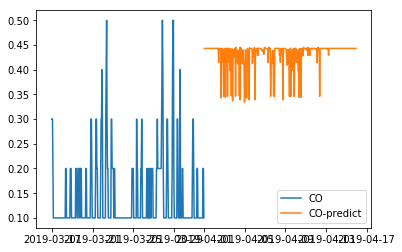

In [44]:
# CO

df_all = pd.merge(pd.DataFrame(datos_actuales['CO'][-horas_a_predecir:]), 
                  pd.DataFrame(datos_prediccion['CO']), 
                  how = 'outer', left_index=True, right_index=True)
plt.plot(df_all)
plt.legend(('CO', 'CO-predict'))

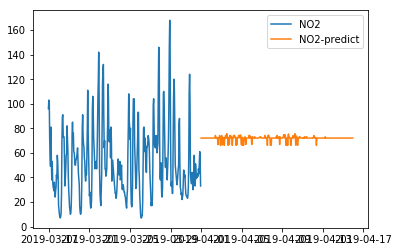

In [45]:
# NO2

df_all = pd.merge(pd.DataFrame(datos_actuales['NO2'][-horas_a_predecir:]), 
                  pd.DataFrame(datos_prediccion['NO2']), 
                  how = 'outer', left_index=True, right_index=True)
plt.plot(df_all)
plt.legend(('NO2', 'NO2-predict'))

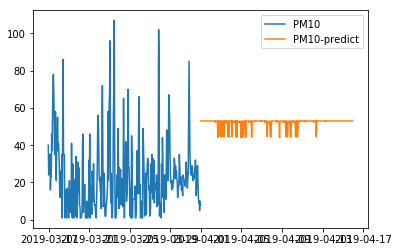

In [46]:
# PM10

df_all = pd.merge(pd.DataFrame(datos_actuales['PM10'][-horas_a_predecir:]), 
                  pd.DataFrame(datos_prediccion['PM10']), 
                  how = 'outer', left_index=True, right_index=True)
plt.plot(df_all)
plt.legend(('PM10', 'PM10-predict'))

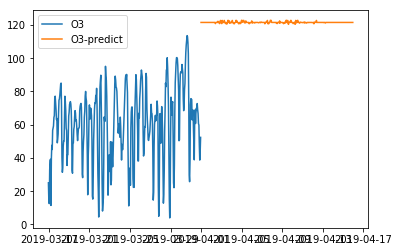

In [47]:
# O3

df_all = pd.merge(pd.DataFrame(datos_actuales['O3'][-horas_a_predecir:]), 
                  pd.DataFrame(datos_prediccion['O3']), 
                  how = 'outer', left_index=True, right_index=True)
plt.plot(df_all)
plt.legend(('O3', 'O3-predict'))